# Отчет

Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import pickle

## Модуль А. Загрузка, подготовка и предварительное изучение данных

### Загрузка данных. Изучение типов данных

In [2]:
data = pd.read_csv("../data/COVID-19.csv")
data

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cdc_report_dt pos_spec_dt    onset_dt             current_status  \
0          2020/11/10  2020/11/10         NaN  Laboratory-confirmed case   
1          2020/11/14  2020/11/10  2020/11/10  Laboratory-confirmed case   
2          2020/11/19  2020/11/10  2020/11/09  Laboratory-confirmed case   
3          2020/11/14  2020/11/10         NaN  Laboratory-confirmed case   
4          2020/11/13  2020/11/10  2020/11/10  Laboratory-confirmed case   
...               ...         ...         ...                        ...   
8405074    2020/10/22         NaN         NaN              Probable Case   
8405075    2020/10/25         NaN         NaN  Laboratory-confirmed case   
8405076    2020/07/18         NaN         NaN  Laboratory-confirmed case   
8405077    2020/11/19         NaN         NaN  Laboratory-confirmed case   
8405078    2020/11/03         NaN         NaN  Laboratory-confirmed case   

             sex      age_group Race and ethnicity (combined)  hosp_yn  \
0           Male  10 - 19 Years           Black, Non-Hispanic       No   
1           Male  10 - 19 Years           Black, Non-Hispanic       No   
2           Male  10 - 19 Years           Black, Non-Hispanic       No   
3           Male  10 - 19 Years           Black, Non-Hispanic  Missing   
4           Male  10 - 19 Years           Black, Non-Hispanic       No   
...          ...            ...                           ...      ...   
8405074  Missing  30 - 39 Years                       Unknown       No   
8405075  Missing  30 - 39 Years                       Unknown  Missing   
8405076  Missing  30 - 39 Years                       Unknown  Missing   
8405077  Missing  30 - 39 Years                       Unknown  Missing   
8405078  Missing  30 - 39 Years                       Unknown       No   

          icu_yn death_yn medcond_yn  
0        Unknown       No         No  
1             No       No         No  
2             No       No         No  
3        Missing       No    Missing  
4             No       No        Yes  
...          ...      ...        ...  
8405074  Unknown       No    Missing  
8405075  Missing  Missing    Missing  
8405076  Missing  Missing    Missing  
8405077  Missing  Missing    Missing  
8405078  Unknown       No    Missing  

[8405079 rows x 11 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 705.4+ MB


В предложенном наборе данных все признаки являются категориальными

### Обработка пропущенных значений

Посмотрим на количество пропущенных значений признаков в виде процента пропущенных значений
каждого признака от количества всех объектов в наборе данных

In [4]:
data.isnull().sum() / data.shape[0] * 100

cdc_report_dt                     0.000000
pos_spec_dt                      65.844592
onset_dt                         47.698802
current_status                    0.000000
sex                               0.000214
age_group                         0.001059
Race and ethnicity (combined)     0.000083
hosp_yn                           0.000000
icu_yn                            0.000000
death_yn                          0.000000
medcond_yn                        0.000000
dtype: float64

Заполним пропущенные значения признаков, кроме pos_spec_dt и onset_dt наиболее часто встречающимися
значениями

In [5]:
features_to_fill = ["sex", "age_group", "Race and ethnicity (combined)"]

for feature in features_to_fill:
    mode = data[feature].value_counts()[0]
    data[feature].fillna(mode, inplace=True)

Признаки pos_spec_dt и onset_dt имеют много пропущенных значений, удалим их

In [6]:
data.drop(["pos_spec_dt", "onset_dt"], axis=1, inplace=True)
data

cdc_report_dt             current_status      sex      age_group  \
0          2020/11/10  Laboratory-confirmed case     Male  10 - 19 Years   
1          2020/11/14  Laboratory-confirmed case     Male  10 - 19 Years   
2          2020/11/19  Laboratory-confirmed case     Male  10 - 19 Years   
3          2020/11/14  Laboratory-confirmed case     Male  10 - 19 Years   
4          2020/11/13  Laboratory-confirmed case     Male  10 - 19 Years   
...               ...                        ...      ...            ...   
8405074    2020/10/22              Probable Case  Missing  30 - 39 Years   
8405075    2020/10/25  Laboratory-confirmed case  Missing  30 - 39 Years   
8405076    2020/07/18  Laboratory-confirmed case  Missing  30 - 39 Years   
8405077    2020/11/19  Laboratory-confirmed case  Missing  30 - 39 Years   
8405078    2020/11/03  Laboratory-confirmed case  Missing  30 - 39 Years   

        Race and ethnicity (combined)  hosp_yn   icu_yn death_yn medcond_yn  
0                 Black, Non-Hispanic       No  Unknown       No         No  
1                 Black, Non-Hispanic       No       No       No         No  
2                 Black, Non-Hispanic       No       No       No         No  
3                 Black, Non-Hispanic  Missing  Missing       No    Missing  
4                 Black, Non-Hispanic       No       No       No        Yes  
...                               ...      ...      ...      ...        ...  
8405074                       Unknown       No  Unknown       No    Missing  
8405075                       Unknown  Missing  Missing  Missing    Missing  
8405076                       Unknown  Missing  Missing  Missing    Missing  
8405077                       Unknown  Missing  Missing  Missing    Missing  
8405078                       Unknown       No  Unknown       No    Missing  

[8405079 rows x 9 columns]

In [7]:
data.isnull().sum() / data.shape[0] * 100

cdc_report_dt                    0.0
current_status                   0.0
sex                              0.0
age_group                        0.0
Race and ethnicity (combined)    0.0
hosp_yn                          0.0
icu_yn                           0.0
death_yn                         0.0
medcond_yn                       0.0
dtype: float64

### Обработка составного признака (cdc_report_dt)

In [8]:
data[["cdc_report_year", "cdc_report_month", "cdc_report_day"]] = data["cdc_report_dt"].str.split("/", expand=True)
data.drop("cdc_report_dt", axis=1, inplace=True)
data

current_status      sex      age_group  \
0        Laboratory-confirmed case     Male  10 - 19 Years   
1        Laboratory-confirmed case     Male  10 - 19 Years   
2        Laboratory-confirmed case     Male  10 - 19 Years   
3        Laboratory-confirmed case     Male  10 - 19 Years   
4        Laboratory-confirmed case     Male  10 - 19 Years   
...                            ...      ...            ...   
8405074              Probable Case  Missing  30 - 39 Years   
8405075  Laboratory-confirmed case  Missing  30 - 39 Years   
8405076  Laboratory-confirmed case  Missing  30 - 39 Years   
8405077  Laboratory-confirmed case  Missing  30 - 39 Years   
8405078  Laboratory-confirmed case  Missing  30 - 39 Years   

        Race and ethnicity (combined)  hosp_yn   icu_yn death_yn medcond_yn  \
0                 Black, Non-Hispanic       No  Unknown       No         No   
1                 Black, Non-Hispanic       No       No       No         No   
2                 Black, Non-Hispanic       No       No       No         No   
3                 Black, Non-Hispanic  Missing  Missing       No    Missing   
4                 Black, Non-Hispanic       No       No       No        Yes   
...                               ...      ...      ...      ...        ...   
8405074                       Unknown       No  Unknown       No    Missing   
8405075                       Unknown  Missing  Missing  Missing    Missing   
8405076                       Unknown  Missing  Missing  Missing    Missing   
8405077                       Unknown  Missing  Missing  Missing    Missing   
8405078                       Unknown       No  Unknown       No    Missing   

        cdc_report_year cdc_report_month cdc_report_day  
0                  2020               11             10  
1                  2020               11             14  
2                  2020               11             19  
3                  2020               11             14  
4                  2020               11             13  
...                 ...              ...            ...  
8405074            2020               10             22  
8405075            2020               10             25  
8405076            2020               07             18  
8405077            2020               11             19  
8405078            2020               11             03  

[8405079 rows x 11 columns]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   current_status                 object
 1   sex                            object
 2   age_group                      object
 3   Race and ethnicity (combined)  object
 4   hosp_yn                        object
 5   icu_yn                         object
 6   death_yn                       object
 7   medcond_yn                     object
 8   cdc_report_year                object
 9   cdc_report_month               object
 10  cdc_report_day                 object
dtypes: object(11)
memory usage: 705.4+ MB


In [10]:
data[["cdc_report_year", "cdc_report_month", "cdc_report_day"]] = data[["cdc_report_year", "cdc_report_month", "cdc_report_day"]].astype("int64")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   current_status                 object
 1   sex                            object
 2   age_group                      object
 3   Race and ethnicity (combined)  object
 4   hosp_yn                        object
 5   icu_yn                         object
 6   death_yn                       object
 7   medcond_yn                     object
 8   cdc_report_year                int64 
 9   cdc_report_month               int64 
 10  cdc_report_day                 int64 
dtypes: int64(3), object(8)
memory usage: 705.4+ MB


### Изучение значений признаков

In [11]:
data.drop(["cdc_report_year", "cdc_report_month", "cdc_report_day"], axis=1).describe().transpose()

count unique                        top  \
current_status                 8405079      2  Laboratory-confirmed case   
sex                            8405079      6                     Female   
age_group                      8405079     11              20 - 29 Years   
Race and ethnicity (combined)  8405079     10                    Unknown   
hosp_yn                        8405079      4                         No   
icu_yn                         8405079      4                    Missing   
death_yn                       8405079      4                         No   
medcond_yn                     8405079      4                    Missing   

                                  freq  
current_status                 7910118  
sex                            4340898  
age_group                      1635264  
Race and ethnicity (combined)  2781176  
hosp_yn                        3502556  
icu_yn                         6178281  
death_yn                       3690813  
medcond_yn                     6063390

In [12]:
def show_unique_values(data):
    for feature in data.drop(["cdc_report_year", "cdc_report_month", "cdc_report_day"], axis=1):
        print(f"Уникальные значения признака {feature}:")
        print(data[feature].unique())

In [13]:
show_unique_values(data)

Уникальные значения признака current_status:
['Laboratory-confirmed case' 'Probable Case']
Уникальные значения признака sex:
['Male' 'Unknown' 'Missing' 'Female' 'Other' 4340898]
Уникальные значения признака age_group:
['10 - 19 Years' '20 - 29 Years' '30 - 39 Years' '40 - 49 Years'
 '50 - 59 Years' '0 - 9 Years' '60 - 69 Years' '80+ Years' '70 - 79 Years'
 1635264 'Unknown']
Уникальные значения признака Race and ethnicity (combined):
['Black, Non-Hispanic' 'White, Non-Hispanic' 'Unknown'
 'Asian, Non-Hispanic' 'American Indian/Alaska Native, Non-Hispanic'
 'Multiple/Other, Non-Hispanic' 'Missing'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic' 'Hispanic/Latino'
 2781176]
Уникальные значения признака hosp_yn:
['No' 'Missing' 'Unknown' 'Yes']
Уникальные значения признака icu_yn:
['Unknown' 'No' 'Missing' 'Yes']
Уникальные значения признака death_yn:
['No' 'Missing' 'Unknown' 'Yes']
Уникальные значения признака medcond_yn:
['No' 'Missing' 'Yes' 'Unknown']


In [14]:
data = pd.DataFrame(data=data[data["death_yn"].isin(["Yes", "No"])])
data

current_status      sex      age_group  \
0        Laboratory-confirmed case     Male  10 - 19 Years   
1        Laboratory-confirmed case     Male  10 - 19 Years   
2        Laboratory-confirmed case     Male  10 - 19 Years   
3        Laboratory-confirmed case     Male  10 - 19 Years   
4        Laboratory-confirmed case     Male  10 - 19 Years   
...                            ...      ...            ...   
8405070  Laboratory-confirmed case  Missing  30 - 39 Years   
8405071              Probable Case  Missing  30 - 39 Years   
8405073              Probable Case  Missing  30 - 39 Years   
8405074              Probable Case  Missing  30 - 39 Years   
8405078  Laboratory-confirmed case  Missing  30 - 39 Years   

        Race and ethnicity (combined)  hosp_yn   icu_yn death_yn medcond_yn  \
0                 Black, Non-Hispanic       No  Unknown       No         No   
1                 Black, Non-Hispanic       No       No       No         No   
2                 Black, Non-Hispanic       No       No       No         No   
3                 Black, Non-Hispanic  Missing  Missing       No    Missing   
4                 Black, Non-Hispanic       No       No       No        Yes   
...                               ...      ...      ...      ...        ...   
8405070                       Unknown       No  Missing       No    Missing   
8405071                       Unknown  Unknown       No       No    Missing   
8405073                       Unknown  Unknown  Unknown       No    Missing   
8405074                       Unknown       No  Unknown       No    Missing   
8405078                       Unknown       No  Unknown       No    Missing   

         cdc_report_year  cdc_report_month  cdc_report_day  
0                   2020                11              10  
1                   2020                11              14  
2                   2020                11              19  
3                   2020                11              14  
4                   2020                11              13  
...                  ...               ...             ...  
8405070             2020                 7              18  
8405071             2020                 8              14  
8405073             2020                11               1  
8405074             2020                10              22  
8405078             2020                11               3  

[3874390 rows x 11 columns]

In [15]:
data = pd.DataFrame(data[data["sex"].isin(["Male", "Female", "Other"])])

In [16]:
data = pd.DataFrame(data[data["Race and ethnicity (combined)"]!=2781176])

In [17]:
data = pd.DataFrame(data[data["age_group"]!=1635264])
data

current_status     sex      age_group  \
0        Laboratory-confirmed case    Male  10 - 19 Years   
1        Laboratory-confirmed case    Male  10 - 19 Years   
2        Laboratory-confirmed case    Male  10 - 19 Years   
3        Laboratory-confirmed case    Male  10 - 19 Years   
4        Laboratory-confirmed case    Male  10 - 19 Years   
...                            ...     ...            ...   
8404668  Laboratory-confirmed case  Female  30 - 39 Years   
8404669  Laboratory-confirmed case  Female  30 - 39 Years   
8404670  Laboratory-confirmed case  Female  30 - 39 Years   
8404671  Laboratory-confirmed case  Female  30 - 39 Years   
8404673  Laboratory-confirmed case  Female  30 - 39 Years   

        Race and ethnicity (combined)  hosp_yn   icu_yn death_yn medcond_yn  \
0                 Black, Non-Hispanic       No  Unknown       No         No   
1                 Black, Non-Hispanic       No       No       No         No   
2                 Black, Non-Hispanic       No       No       No         No   
3                 Black, Non-Hispanic  Missing  Missing       No    Missing   
4                 Black, Non-Hispanic       No       No       No        Yes   
...                               ...      ...      ...      ...        ...   
8404668               Hispanic/Latino       No  Missing       No    Missing   
8404669               Hispanic/Latino       No       No       No    Missing   
8404670               Hispanic/Latino  Unknown  Missing       No    Missing   
8404671               Hispanic/Latino       No  Unknown       No        Yes   
8404673               Hispanic/Latino      Yes  Missing       No    Missing   

         cdc_report_year  cdc_report_month  cdc_report_day  
0                   2020                11              10  
1                   2020                11              14  
2                   2020                11              19  
3                   2020                11              14  
4                   2020                11              13  
...                  ...               ...             ...  
8404668             2020                 4              18  
8404669             2020                 8              24  
8404670             2020                 9              15  
8404671             2020                 6              10  
8404673             2020                 7              30  

[3854274 rows x 11 columns]

In [18]:
show_unique_values(data)

Уникальные значения признака current_status:
['Laboratory-confirmed case' 'Probable Case']
Уникальные значения признака sex:
['Male' 'Female' 'Other']
Уникальные значения признака age_group:
['10 - 19 Years' '20 - 29 Years' '30 - 39 Years' '40 - 49 Years'
 '50 - 59 Years' '0 - 9 Years' '60 - 69 Years' '80+ Years' '70 - 79 Years'
 'Unknown']
Уникальные значения признака Race and ethnicity (combined):
['Black, Non-Hispanic' 'American Indian/Alaska Native, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic'
 'White, Non-Hispanic' 'Missing' 'Hispanic/Latino' 'Unknown'
 'Asian, Non-Hispanic' 'Multiple/Other, Non-Hispanic']
Уникальные значения признака hosp_yn:
['No' 'Missing' 'Unknown' 'Yes']
Уникальные значения признака icu_yn:
['Unknown' 'No' 'Missing' 'Yes']
Уникальные значения признака death_yn:
['No' 'Yes']
Уникальные значения признака medcond_yn:
['No' 'Missing' 'Yes' 'Unknown']


### Перекодирование значений бинарных признаков

In [19]:
data["death_yn"] = data["death_yn"].replace({"Yes": 1, "No": 0})

### Визуализация данных

Попарные диаграммы

<Figure size 1296x1296 with 0 Axes>

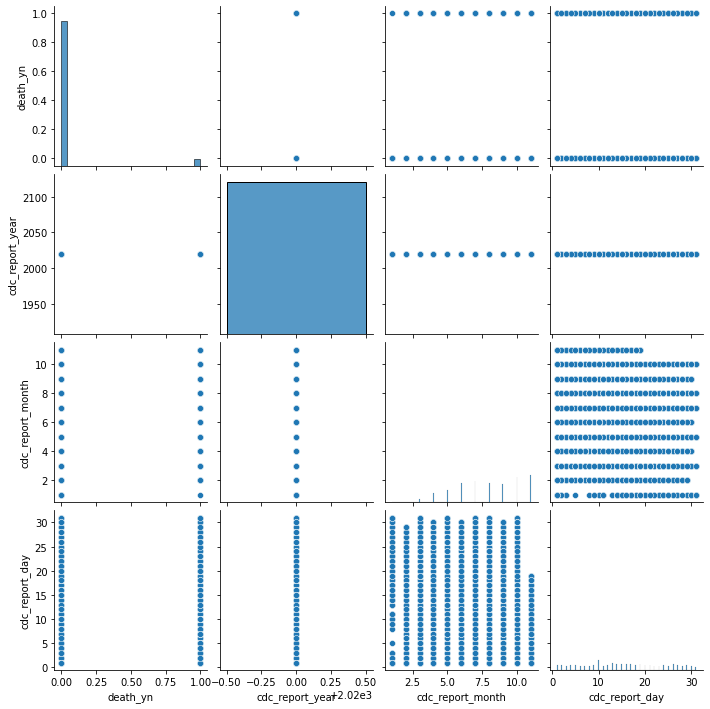

In [20]:
plt.figure(figsize=(18,18))
sns.pairplot(data);

Распределение значений целевого признака

<AxesSubplot:xlabel='death_yn', ylabel='count'>

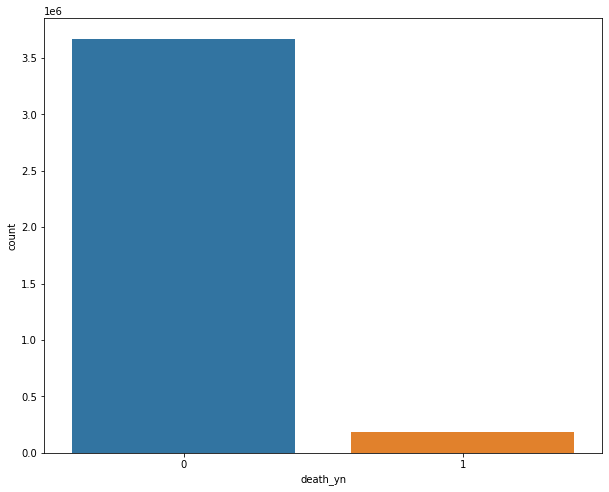

In [21]:
plt.figure(figsize=(10,8))
sns.countplot(x="death_yn", data=data)

### Перекодирование значений категориальных признаков

In [22]:
data

current_status     sex      age_group  \
0        Laboratory-confirmed case    Male  10 - 19 Years   
1        Laboratory-confirmed case    Male  10 - 19 Years   
2        Laboratory-confirmed case    Male  10 - 19 Years   
3        Laboratory-confirmed case    Male  10 - 19 Years   
4        Laboratory-confirmed case    Male  10 - 19 Years   
...                            ...     ...            ...   
8404668  Laboratory-confirmed case  Female  30 - 39 Years   
8404669  Laboratory-confirmed case  Female  30 - 39 Years   
8404670  Laboratory-confirmed case  Female  30 - 39 Years   
8404671  Laboratory-confirmed case  Female  30 - 39 Years   
8404673  Laboratory-confirmed case  Female  30 - 39 Years   

        Race and ethnicity (combined)  hosp_yn   icu_yn  death_yn medcond_yn  \
0                 Black, Non-Hispanic       No  Unknown         0         No   
1                 Black, Non-Hispanic       No       No         0         No   
2                 Black, Non-Hispanic       No       No         0         No   
3                 Black, Non-Hispanic  Missing  Missing         0    Missing   
4                 Black, Non-Hispanic       No       No         0        Yes   
...                               ...      ...      ...       ...        ...   
8404668               Hispanic/Latino       No  Missing         0    Missing   
8404669               Hispanic/Latino       No       No         0    Missing   
8404670               Hispanic/Latino  Unknown  Missing         0    Missing   
8404671               Hispanic/Latino       No  Unknown         0        Yes   
8404673               Hispanic/Latino      Yes  Missing         0    Missing   

         cdc_report_year  cdc_report_month  cdc_report_day  
0                   2020                11              10  
1                   2020                11              14  
2                   2020                11              19  
3                   2020                11              14  
4                   2020                11              13  
...                  ...               ...             ...  
8404668             2020                 4              18  
8404669             2020                 8              24  
8404670             2020                 9              15  
8404671             2020                 6              10  
8404673             2020                 7              30  

[3854274 rows x 11 columns]

In [23]:
data = pd.get_dummies(columns=["age_group","current_status","sex",
                               "Race and ethnicity (combined)","hosp_yn",
                               "icu_yn", "medcond_yn"],
                      prefix={"age_group": "age",
                              "current_status": "status",
                              "sex": "sex",
                              "Race and ethnicity (combined)": "race",
                              "hosp_yn": "hosp_yn",
                              "icu_yn": "icu_yn",
                              "medcond_yn": "medcond_yn"},
                      data=data)

In [24]:
data

death_yn  cdc_report_year  cdc_report_month  cdc_report_day  \
0               0             2020                11              10   
1               0             2020                11              14   
2               0             2020                11              19   
3               0             2020                11              14   
4               0             2020                11              13   
...           ...              ...               ...             ...   
8404668         0             2020                 4              18   
8404669         0             2020                 8              24   
8404670         0             2020                 9              15   
8404671         0             2020                 6              10   
8404673         0             2020                 7              30   

         age_0 - 9 Years  age_10 - 19 Years  age_20 - 29 Years  \
0                      0                  1                  0   
1                      0                  1                  0   
2                      0                  1                  0   
3                      0                  1                  0   
4                      0                  1                  0   
...                  ...                ...                ...   
8404668                0                  0                  0   
8404669                0                  0                  0   
8404670                0                  0                  0   
8404671                0                  0                  0   
8404673                0                  0                  0   

         age_30 - 39 Years  age_40 - 49 Years  age_50 - 59 Years  ...  \
0                        0                  0                  0  ...   
1                        0                  0                  0  ...   
2                        0                  0                  0  ...   
3                        0                  0                  0  ...   
4                        0                  0                  0  ...   
...                    ...                ...                ...  ...   
8404668                  1                  0                  0  ...   
8404669                  1                  0                  0  ...   
8404670                  1                  0                  0  ...   
8404671                  1                  0                  0  ...   
8404673                  1                  0                  0  ...   

         hosp_yn_Unknown  hosp_yn_Yes  icu_yn_Missing  icu_yn_No  \
0                      0            0               0          0   
1                      0            0               0          1   
2                      0            0               0          1   
3                      0            0               1          0   
4                      0            0               0          1   
...                  ...          ...             ...        ...   
8404668                0            0               1          0   
8404669                0            0               0          1   
8404670                1            0               1          0   
8404671                0            0               0          0   
8404673                0            1               1          0   

         icu_yn_Unknown  icu_yn_Yes  medcond_yn_Missing  medcond_yn_No  \
0                     1           0                   0              1   
1                     0           0                   0              1   
2                     0           0                   0              1   
3                     0           0                   1              0   
4                     0           0                   0              0   
...                 ...         ...                 ...            ...   
8404668               0           0                   1              0   
8404669               0           0                   1          

### Сохранение предобработанных данных

In [25]:
data.to_csv("../data/COVID-19_preprocessed.csv")

## Модуль B. Выделение целевой переменной. Изучение параметров, влияющих на целевую переменную. Построение модели

### Изучение влияния признаков

In [26]:
data["cdc_report_year"].unique()

array([2020], dtype=int64)

Признак cdc_report_year подлежит удалению

Модель будет обучаться на большом множестве объектов, однако
значение признака cdc_report_year у каждого из них будет 2020.

В следствии этого при получении предсказаний год не будет иметь
никакого значения

In [27]:
data.drop(["cdc_report_year"], axis=1, inplace=True)

Посмотрим, как кореллируют между собой значения признаков

<AxesSubplot:>

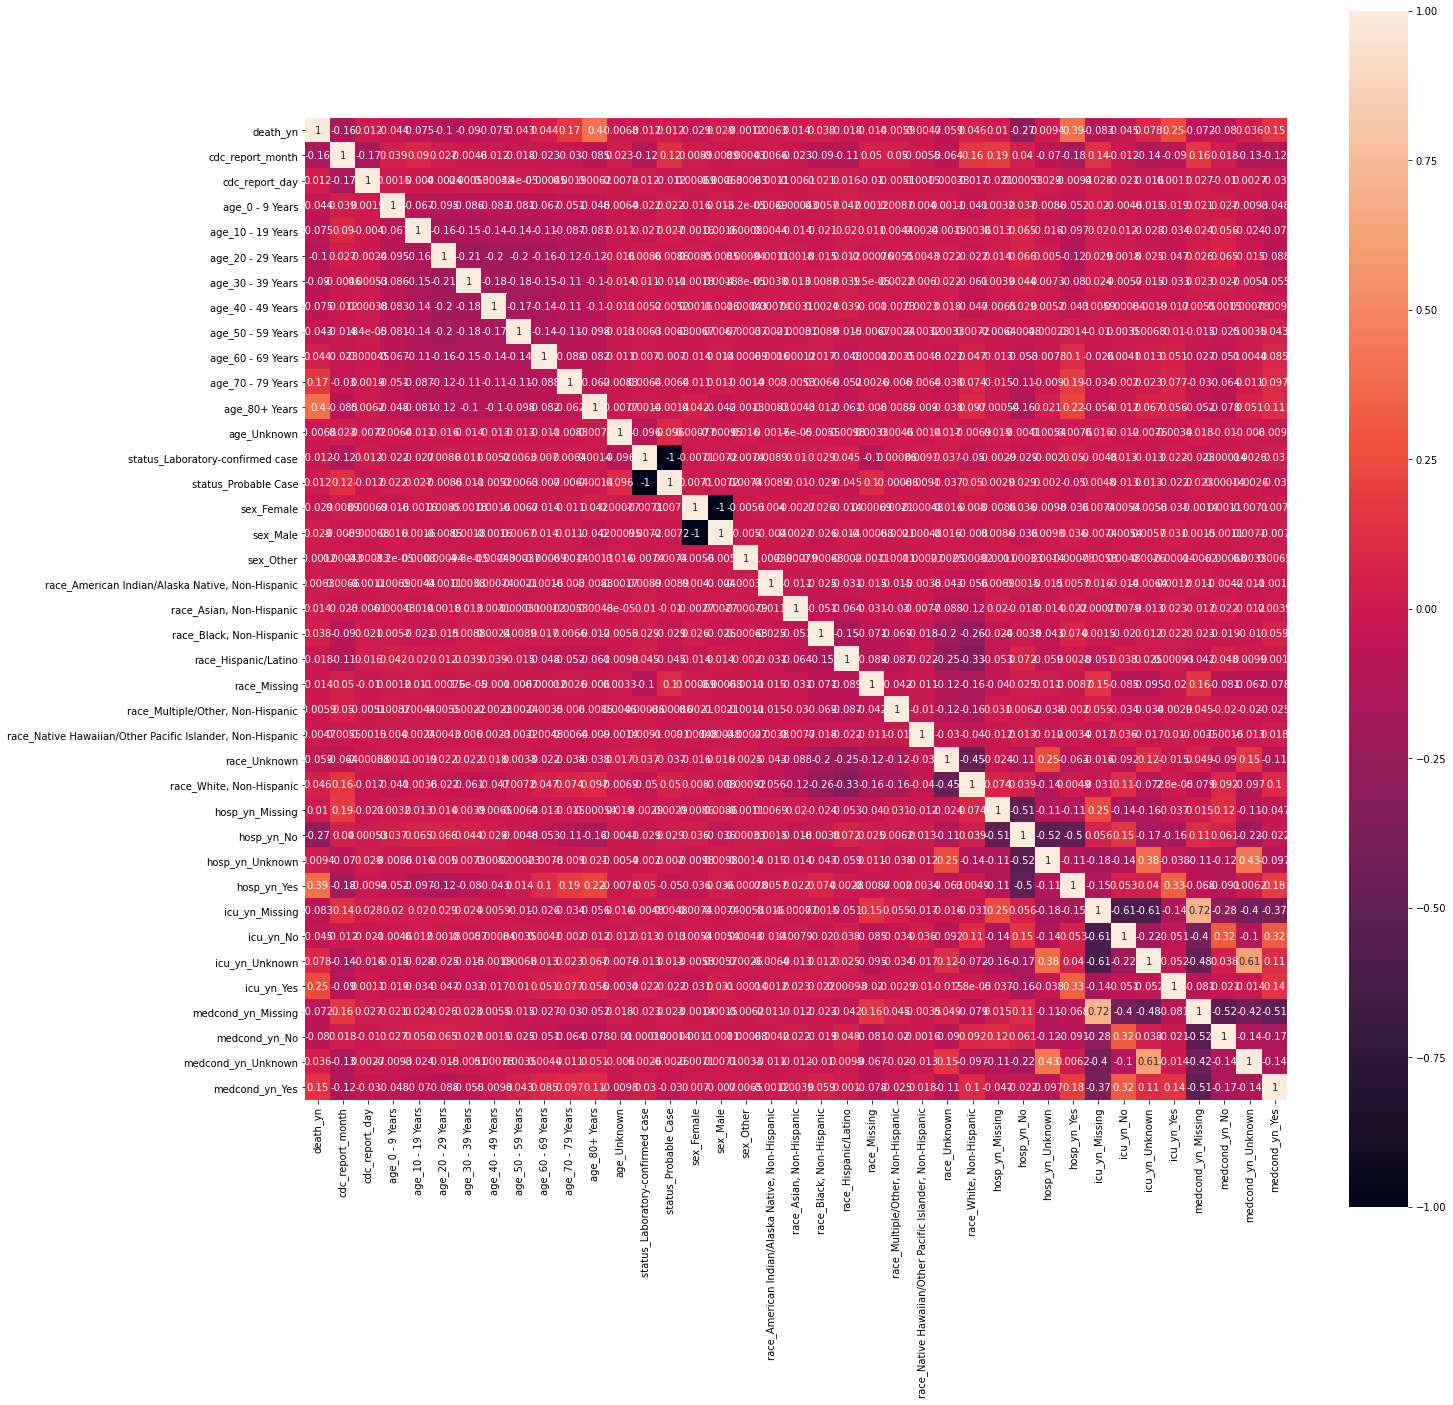

In [28]:
plt.figure(figsize=(22,22))
sns.heatmap(data.corr(), annot=True, square=True)

На данном этапе больше не будем удалять никаких признаков

### Моделирование

#### Разделение выборки на обучающую и тестовую

В предложенном наборе данных значения целевого признака несбалансированы.

In [29]:
print(data[data["death_yn"]==0].shape)
print(data[data["death_yn"]==1].shape)

(3671232, 39)
(183042, 39)


Выберем первые 183042 объекта, где значение целевого признака - 0. При делении выборки на тренировочную и тестовую объекты будут перемешаны

In [30]:
data_death_n = data[data["death_yn"]==0][:183042]
data_death_y = data[data["death_yn"]==1]

In [31]:
data = data_death_n.append(data_death_y)
data.shape[0] // 2

183042

In [32]:
y = data["death_yn"]
X = data.drop("death_yn", axis=1)

Разобьем данные на тренировочную и тестовую выборки

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=123)

Теперь значения целевого признака сбалансированы. При разбиении выборки на тренировочную и тестовую сделаем стратификацию, чтобы сохранить пропорции

Данные поделим в соотношении 67 / 33 на тренировочную и тестовую выборки соответственно

Установим seed генератора случайных чисел, чтобы при перезапуске ноутбука получить то же разбиение

Создадим функцию для вывода на экран метрик качества

In [34]:
def print_model_metrics(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(estimator.score(X_test, y_test))

#### Модель KNeighborsClassifier

In [35]:
params = {"n_neighbors": [3,5]}
grid_search = GridSearchCV(KNeighborsClassifier(), params).fit(X_train, y_train)
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [36]:
knn = grid_search.best_estimator_
print_model_metrics(knn, X_test, y_test)

[[60303   101]
 [  812 59592]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     60404
           1       1.00      0.99      0.99     60404

    accuracy                           0.99    120808
   macro avg       0.99      0.99      0.99    120808
weighted avg       0.99      0.99      0.99    120808

0.9924425534732799


#### Модель RandomForestClassifier

In [37]:
params = {"n_estimators": [100,150,200]}
grid_search = GridSearchCV(RandomForestClassifier(), params).fit(X_train, y_train)
grid_search.best_estimator_

RandomForestClassifier(n_estimators=200)

In [38]:
rf = grid_search.best_estimator_
print_model_metrics(rf, X_test, y_test)

[[60367    37]
 [  130 60274]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60404
           1       1.00      1.00      1.00     60404

    accuracy                           1.00    120808
   macro avg       1.00      1.00      1.00    120808
weighted avg       1.00      1.00      1.00    120808

0.9986176412158135


#### Модель CatBoostClassifier

In [43]:
params = {"n_estimators": [100,150,200]}
grid_search = GridSearchCV(CatBoostClassifier(), params).fit(X_train, y_train)
grid_search.best_estimator_

Learning rate set to 0.5
0:	learn: 0.0427845	total: 263ms	remaining: 26.1s
1:	learn: 0.0156621	total: 300ms	remaining: 14.7s
2:	learn: 0.0108425	total: 340ms	remaining: 11s
3:	learn: 0.0100072	total: 376ms	remaining: 9.02s
4:	learn: 0.0095022	total: 412ms	remaining: 7.84s
5:	learn: 0.0067827	total: 446ms	remaining: 6.99s
6:	learn: 0.0063938	total: 478ms	remaining: 6.36s
7:	learn: 0.0062497	total: 519ms	remaining: 5.97s
8:	learn: 0.0060218	total: 558ms	remaining: 5.64s
9:	learn: 0.0059304	total: 592ms	remaining: 5.33s
10:	learn: 0.0058270	total: 625ms	remaining: 5.06s
11:	learn: 0.0057962	total: 656ms	remaining: 4.81s
12:	learn: 0.0056690	total: 691ms	remaining: 4.63s
13:	learn: 0.0056222	total: 720ms	remaining: 4.42s
14:	learn: 0.0055619	total: 758ms	remaining: 4.3s
15:	learn: 0.0054004	total: 798ms	remaining: 4.19s
16:	learn: 0.0053438	total: 839ms	remaining: 4.09s
17:	learn: 0.0052444	total: 884ms	remaining: 4.03s
18:	learn: 0.0051888	total: 919ms	remaining: 3.92s
19:	learn: 0.005188

64:	learn: 0.0047252	total: 1.94s	remaining: 1.04s
65:	learn: 0.0047252	total: 1.96s	remaining: 1.01s
66:	learn: 0.0047251	total: 1.98s	remaining: 976ms
67:	learn: 0.0047251	total: 2.01s	remaining: 944ms
68:	learn: 0.0047251	total: 2.03s	remaining: 912ms
69:	learn: 0.0047251	total: 2.05s	remaining: 880ms
70:	learn: 0.0047251	total: 2.08s	remaining: 848ms
71:	learn: 0.0047249	total: 2.1s	remaining: 817ms
72:	learn: 0.0047249	total: 2.13s	remaining: 788ms
73:	learn: 0.0047248	total: 2.15s	remaining: 757ms
74:	learn: 0.0047248	total: 2.18s	remaining: 728ms
75:	learn: 0.0047247	total: 2.21s	remaining: 698ms
76:	learn: 0.0047247	total: 2.24s	remaining: 670ms
77:	learn: 0.0046360	total: 2.28s	remaining: 643ms
78:	learn: 0.0045949	total: 2.31s	remaining: 615ms
79:	learn: 0.0045949	total: 2.34s	remaining: 585ms
80:	learn: 0.0045948	total: 2.37s	remaining: 557ms
81:	learn: 0.0045948	total: 2.4s	remaining: 528ms
82:	learn: 0.0045948	total: 2.43s	remaining: 497ms
83:	learn: 0.0045948	total: 2.45s

25:	learn: 0.0048554	total: 884ms	remaining: 2.52s
26:	learn: 0.0048554	total: 908ms	remaining: 2.45s
27:	learn: 0.0047839	total: 940ms	remaining: 2.42s
28:	learn: 0.0047839	total: 967ms	remaining: 2.37s
29:	learn: 0.0047839	total: 988ms	remaining: 2.3s
30:	learn: 0.0047838	total: 1.01s	remaining: 2.25s
31:	learn: 0.0047837	total: 1.03s	remaining: 2.2s
32:	learn: 0.0047836	total: 1.06s	remaining: 2.15s
33:	learn: 0.0047835	total: 1.08s	remaining: 2.1s
34:	learn: 0.0047835	total: 1.11s	remaining: 2.06s
35:	learn: 0.0047835	total: 1.13s	remaining: 2.02s
36:	learn: 0.0047835	total: 1.16s	remaining: 1.97s
37:	learn: 0.0047834	total: 1.18s	remaining: 1.92s
38:	learn: 0.0047834	total: 1.2s	remaining: 1.88s
39:	learn: 0.0047833	total: 1.22s	remaining: 1.84s
40:	learn: 0.0047833	total: 1.25s	remaining: 1.79s
41:	learn: 0.0047833	total: 1.27s	remaining: 1.76s
42:	learn: 0.0047833	total: 1.3s	remaining: 1.72s
43:	learn: 0.0047833	total: 1.32s	remaining: 1.68s
44:	learn: 0.0047833	total: 1.34s	re

91:	learn: 0.0050089	total: 2.7s	remaining: 234ms
92:	learn: 0.0050089	total: 2.72s	remaining: 205ms
93:	learn: 0.0050089	total: 2.74s	remaining: 175ms
94:	learn: 0.0050089	total: 2.77s	remaining: 146ms
95:	learn: 0.0050089	total: 2.79s	remaining: 116ms
96:	learn: 0.0050089	total: 2.82s	remaining: 87.3ms
97:	learn: 0.0050089	total: 2.85s	remaining: 58.1ms
98:	learn: 0.0050089	total: 2.87s	remaining: 29ms
99:	learn: 0.0050089	total: 2.89s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.0427845	total: 40.8ms	remaining: 6.07s
1:	learn: 0.0156621	total: 77.1ms	remaining: 5.7s
2:	learn: 0.0108425	total: 111ms	remaining: 5.42s
3:	learn: 0.0100072	total: 143ms	remaining: 5.24s
4:	learn: 0.0095022	total: 176ms	remaining: 5.11s
5:	learn: 0.0067827	total: 210ms	remaining: 5.05s
6:	learn: 0.0063938	total: 243ms	remaining: 4.97s
7:	learn: 0.0062497	total: 285ms	remaining: 5.06s
8:	learn: 0.0060218	total: 320ms	remaining: 5.01s
9:	learn: 0.0059304	total: 352ms	remaining: 4.93s
10:	learn: 0.0058

4:	learn: 0.0068347	total: 189ms	remaining: 5.48s
5:	learn: 0.0065718	total: 237ms	remaining: 5.68s
6:	learn: 0.0065074	total: 281ms	remaining: 5.74s
7:	learn: 0.0063287	total: 322ms	remaining: 5.71s
8:	learn: 0.0062300	total: 355ms	remaining: 5.57s
9:	learn: 0.0059083	total: 400ms	remaining: 5.59s
10:	learn: 0.0058286	total: 424ms	remaining: 5.36s
11:	learn: 0.0057746	total: 457ms	remaining: 5.26s
12:	learn: 0.0053294	total: 497ms	remaining: 5.23s
13:	learn: 0.0053016	total: 517ms	remaining: 5.03s
14:	learn: 0.0052476	total: 552ms	remaining: 4.97s
15:	learn: 0.0052476	total: 577ms	remaining: 4.83s
16:	learn: 0.0051866	total: 608ms	remaining: 4.76s
17:	learn: 0.0051865	total: 634ms	remaining: 4.65s
18:	learn: 0.0050965	total: 668ms	remaining: 4.6s
19:	learn: 0.0050964	total: 689ms	remaining: 4.48s
20:	learn: 0.0050629	total: 715ms	remaining: 4.39s
21:	learn: 0.0049885	total: 747ms	remaining: 4.34s
22:	learn: 0.0049475	total: 774ms	remaining: 4.27s
23:	learn: 0.0049475	total: 800ms	rema

14:	learn: 0.0062077	total: 648ms	remaining: 5.83s
15:	learn: 0.0061608	total: 694ms	remaining: 5.81s
16:	learn: 0.0060936	total: 736ms	remaining: 5.75s
17:	learn: 0.0058869	total: 778ms	remaining: 5.7s
18:	learn: 0.0056042	total: 830ms	remaining: 5.72s
19:	learn: 0.0055615	total: 874ms	remaining: 5.68s
20:	learn: 0.0053127	total: 913ms	remaining: 5.61s
21:	learn: 0.0052775	total: 959ms	remaining: 5.58s
22:	learn: 0.0052774	total: 994ms	remaining: 5.49s
23:	learn: 0.0052774	total: 1.02s	remaining: 5.36s
24:	learn: 0.0052773	total: 1.06s	remaining: 5.3s
25:	learn: 0.0052773	total: 1.09s	remaining: 5.21s
26:	learn: 0.0052773	total: 1.12s	remaining: 5.12s
27:	learn: 0.0052772	total: 1.15s	remaining: 5.02s
28:	learn: 0.0052772	total: 1.18s	remaining: 4.92s
29:	learn: 0.0052771	total: 1.21s	remaining: 4.83s
30:	learn: 0.0052771	total: 1.24s	remaining: 4.78s
31:	learn: 0.0052771	total: 1.27s	remaining: 4.69s
32:	learn: 0.0052769	total: 1.31s	remaining: 4.63s
33:	learn: 0.0052768	total: 1.34s

31:	learn: 0.0047837	total: 1.31s	remaining: 4.83s
32:	learn: 0.0047836	total: 1.34s	remaining: 4.76s
33:	learn: 0.0047835	total: 1.37s	remaining: 4.69s
34:	learn: 0.0047835	total: 1.4s	remaining: 4.61s
35:	learn: 0.0047835	total: 1.43s	remaining: 4.52s
36:	learn: 0.0047835	total: 1.45s	remaining: 4.43s
37:	learn: 0.0047834	total: 1.48s	remaining: 4.37s
38:	learn: 0.0047834	total: 1.51s	remaining: 4.3s
39:	learn: 0.0047833	total: 1.54s	remaining: 4.24s
40:	learn: 0.0047833	total: 1.57s	remaining: 4.19s
41:	learn: 0.0047833	total: 1.61s	remaining: 4.13s
42:	learn: 0.0047833	total: 1.64s	remaining: 4.08s
43:	learn: 0.0047833	total: 1.67s	remaining: 4.03s
44:	learn: 0.0047833	total: 1.7s	remaining: 3.97s
45:	learn: 0.0047833	total: 1.74s	remaining: 3.92s
46:	learn: 0.0047833	total: 1.77s	remaining: 3.87s
47:	learn: 0.0047833	total: 1.8s	remaining: 3.82s
48:	learn: 0.0047833	total: 1.83s	remaining: 3.77s
49:	learn: 0.0047833	total: 1.85s	remaining: 3.71s
50:	learn: 0.0047833	total: 1.88s	r

51:	learn: 0.0050089	total: 1.53s	remaining: 2.88s
52:	learn: 0.0050089	total: 1.55s	remaining: 2.84s
53:	learn: 0.0050089	total: 1.58s	remaining: 2.81s
54:	learn: 0.0050089	total: 1.6s	remaining: 2.76s
55:	learn: 0.0050089	total: 1.63s	remaining: 2.73s
56:	learn: 0.0050089	total: 1.65s	remaining: 2.69s
57:	learn: 0.0050089	total: 1.67s	remaining: 2.65s
58:	learn: 0.0050089	total: 1.69s	remaining: 2.61s
59:	learn: 0.0050089	total: 1.72s	remaining: 2.58s
60:	learn: 0.0050089	total: 1.74s	remaining: 2.54s
61:	learn: 0.0050089	total: 1.76s	remaining: 2.5s
62:	learn: 0.0050089	total: 1.79s	remaining: 2.47s
63:	learn: 0.0050089	total: 1.81s	remaining: 2.44s
64:	learn: 0.0050089	total: 1.84s	remaining: 2.41s
65:	learn: 0.0050089	total: 1.86s	remaining: 2.37s
66:	learn: 0.0050089	total: 1.89s	remaining: 2.34s
67:	learn: 0.0050089	total: 1.91s	remaining: 2.3s
68:	learn: 0.0050089	total: 1.94s	remaining: 2.28s
69:	learn: 0.0050089	total: 1.96s	remaining: 2.24s
70:	learn: 0.0050089	total: 1.99s	

62:	learn: 0.0048798	total: 1.99s	remaining: 4.33s
63:	learn: 0.0048798	total: 2.02s	remaining: 4.28s
64:	learn: 0.0048798	total: 2.04s	remaining: 4.23s
65:	learn: 0.0048798	total: 2.06s	remaining: 4.18s
66:	learn: 0.0048798	total: 2.08s	remaining: 4.13s
67:	learn: 0.0048798	total: 2.1s	remaining: 4.08s
68:	learn: 0.0048798	total: 2.13s	remaining: 4.04s
69:	learn: 0.0048798	total: 2.15s	remaining: 4s
70:	learn: 0.0048798	total: 2.18s	remaining: 3.95s
71:	learn: 0.0048798	total: 2.2s	remaining: 3.91s
72:	learn: 0.0048798	total: 2.22s	remaining: 3.86s
73:	learn: 0.0048798	total: 2.25s	remaining: 3.82s
74:	learn: 0.0048798	total: 2.27s	remaining: 3.77s
75:	learn: 0.0048798	total: 2.29s	remaining: 3.73s
76:	learn: 0.0048798	total: 2.31s	remaining: 3.69s
77:	learn: 0.0048798	total: 2.33s	remaining: 3.65s
78:	learn: 0.0048798	total: 2.35s	remaining: 3.6s
79:	learn: 0.0048798	total: 2.38s	remaining: 3.56s
80:	learn: 0.0048798	total: 2.4s	remaining: 3.52s
81:	learn: 0.0048798	total: 2.42s	rema

26:	learn: 0.0052101	total: 856ms	remaining: 5.48s
27:	learn: 0.0052100	total: 885ms	remaining: 5.44s
28:	learn: 0.0052100	total: 917ms	remaining: 5.41s
29:	learn: 0.0052100	total: 942ms	remaining: 5.34s
30:	learn: 0.0052100	total: 968ms	remaining: 5.28s
31:	learn: 0.0052100	total: 993ms	remaining: 5.21s
32:	learn: 0.0052100	total: 1.02s	remaining: 5.18s
33:	learn: 0.0052099	total: 1.05s	remaining: 5.11s
34:	learn: 0.0052099	total: 1.07s	remaining: 5.07s
35:	learn: 0.0052099	total: 1.1s	remaining: 5.02s
36:	learn: 0.0052099	total: 1.13s	remaining: 4.97s
37:	learn: 0.0052099	total: 1.15s	remaining: 4.9s
38:	learn: 0.0052099	total: 1.17s	remaining: 4.84s
39:	learn: 0.0052099	total: 1.2s	remaining: 4.81s
40:	learn: 0.0052098	total: 1.23s	remaining: 4.77s
41:	learn: 0.0052098	total: 1.25s	remaining: 4.7s
42:	learn: 0.0052098	total: 1.27s	remaining: 4.65s
43:	learn: 0.0052098	total: 1.3s	remaining: 4.62s
44:	learn: 0.0052098	total: 1.33s	remaining: 4.57s
45:	learn: 0.0052097	total: 1.35s	re

187:	learn: 0.0052096	total: 3.91s	remaining: 250ms
188:	learn: 0.0052096	total: 3.93s	remaining: 229ms
189:	learn: 0.0052096	total: 3.95s	remaining: 208ms
190:	learn: 0.0052096	total: 3.96s	remaining: 187ms
191:	learn: 0.0052096	total: 3.98s	remaining: 166ms
192:	learn: 0.0052096	total: 4s	remaining: 145ms
193:	learn: 0.0052096	total: 4.01s	remaining: 124ms
194:	learn: 0.0052096	total: 4.03s	remaining: 103ms
195:	learn: 0.0052096	total: 4.04s	remaining: 82.6ms
196:	learn: 0.0052096	total: 4.07s	remaining: 61.9ms
197:	learn: 0.0052096	total: 4.08s	remaining: 41.3ms
198:	learn: 0.0052096	total: 4.1s	remaining: 20.6ms
199:	learn: 0.0052096	total: 4.12s	remaining: 0us
Learning rate set to 0.429429
0:	learn: 0.0493836	total: 33.2ms	remaining: 6.61s
1:	learn: 0.0158801	total: 75.8ms	remaining: 7.5s
2:	learn: 0.0117089	total: 104ms	remaining: 6.84s
3:	learn: 0.0085911	total: 136ms	remaining: 6.67s
4:	learn: 0.0079162	total: 164ms	remaining: 6.39s
5:	learn: 0.0077275	total: 197ms	remaining: 6

147:	learn: 0.0048512	total: 3.67s	remaining: 1.29s
148:	learn: 0.0048512	total: 3.69s	remaining: 1.26s
149:	learn: 0.0048512	total: 3.71s	remaining: 1.24s
150:	learn: 0.0048512	total: 3.73s	remaining: 1.21s
151:	learn: 0.0048512	total: 3.76s	remaining: 1.19s
152:	learn: 0.0048512	total: 3.78s	remaining: 1.16s
153:	learn: 0.0048512	total: 3.8s	remaining: 1.13s
154:	learn: 0.0048512	total: 3.82s	remaining: 1.11s
155:	learn: 0.0048512	total: 3.84s	remaining: 1.08s
156:	learn: 0.0048512	total: 3.86s	remaining: 1.06s
157:	learn: 0.0048511	total: 3.89s	remaining: 1.03s
158:	learn: 0.0048511	total: 3.91s	remaining: 1.01s
159:	learn: 0.0048511	total: 3.93s	remaining: 983ms
160:	learn: 0.0048511	total: 3.96s	remaining: 958ms
161:	learn: 0.0048511	total: 3.98s	remaining: 934ms
162:	learn: 0.0048511	total: 4s	remaining: 908ms
163:	learn: 0.0048511	total: 4.03s	remaining: 884ms
164:	learn: 0.0048511	total: 4.05s	remaining: 860ms
165:	learn: 0.0048511	total: 4.09s	remaining: 838ms
166:	learn: 0.00

107:	learn: 0.0049586	total: 2.91s	remaining: 2.48s
108:	learn: 0.0049586	total: 2.94s	remaining: 2.45s
109:	learn: 0.0049585	total: 2.96s	remaining: 2.42s
110:	learn: 0.0049585	total: 2.99s	remaining: 2.4s
111:	learn: 0.0049584	total: 3.02s	remaining: 2.37s
112:	learn: 0.0049584	total: 3.04s	remaining: 2.34s
113:	learn: 0.0049583	total: 3.07s	remaining: 2.32s
114:	learn: 0.0049583	total: 3.1s	remaining: 2.29s
115:	learn: 0.0049582	total: 3.13s	remaining: 2.27s
116:	learn: 0.0049582	total: 3.16s	remaining: 2.24s
117:	learn: 0.0049582	total: 3.19s	remaining: 2.21s
118:	learn: 0.0049581	total: 3.22s	remaining: 2.19s
119:	learn: 0.0049581	total: 3.25s	remaining: 2.16s
120:	learn: 0.0049581	total: 3.27s	remaining: 2.14s
121:	learn: 0.0049580	total: 3.3s	remaining: 2.11s
122:	learn: 0.0049580	total: 3.33s	remaining: 2.09s
123:	learn: 0.0049580	total: 3.37s	remaining: 2.07s
124:	learn: 0.0049579	total: 3.4s	remaining: 2.04s
125:	learn: 0.0049579	total: 3.42s	remaining: 2.01s
126:	learn: 0.00

72:	learn: 0.0052577	total: 1.94s	remaining: 3.37s
73:	learn: 0.0052577	total: 1.96s	remaining: 3.33s
74:	learn: 0.0052577	total: 1.98s	remaining: 3.29s
75:	learn: 0.0052576	total: 2s	remaining: 3.26s
76:	learn: 0.0052576	total: 2.02s	remaining: 3.24s
77:	learn: 0.0052576	total: 2.05s	remaining: 3.2s
78:	learn: 0.0052576	total: 2.07s	remaining: 3.18s
79:	learn: 0.0052575	total: 2.1s	remaining: 3.15s
80:	learn: 0.0052575	total: 2.12s	remaining: 3.12s
81:	learn: 0.0052575	total: 2.15s	remaining: 3.09s
82:	learn: 0.0052574	total: 2.17s	remaining: 3.06s
83:	learn: 0.0052574	total: 2.19s	remaining: 3.03s
84:	learn: 0.0052574	total: 2.22s	remaining: 3s
85:	learn: 0.0052574	total: 2.24s	remaining: 2.97s
86:	learn: 0.0052574	total: 2.26s	remaining: 2.94s
87:	learn: 0.0052573	total: 2.28s	remaining: 2.91s
88:	learn: 0.0052573	total: 2.31s	remaining: 2.88s
89:	learn: 0.0052573	total: 2.33s	remaining: 2.85s
90:	learn: 0.0052573	total: 2.35s	remaining: 2.82s
91:	learn: 0.0052573	total: 2.38s	remai

34:	learn: 0.0049146	total: 1.38s	remaining: 6.51s
35:	learn: 0.0049146	total: 1.42s	remaining: 6.45s
36:	learn: 0.0049146	total: 1.45s	remaining: 6.37s
37:	learn: 0.0049146	total: 1.48s	remaining: 6.3s
38:	learn: 0.0049146	total: 1.5s	remaining: 6.22s
39:	learn: 0.0049146	total: 1.54s	remaining: 6.14s
40:	learn: 0.0049146	total: 1.57s	remaining: 6.09s
41:	learn: 0.0049146	total: 1.6s	remaining: 6.02s
42:	learn: 0.0049146	total: 1.63s	remaining: 5.95s
43:	learn: 0.0049146	total: 1.66s	remaining: 5.88s
44:	learn: 0.0049146	total: 1.69s	remaining: 5.82s
45:	learn: 0.0049146	total: 1.72s	remaining: 5.76s
46:	learn: 0.0049146	total: 1.75s	remaining: 5.68s
47:	learn: 0.0049146	total: 1.77s	remaining: 5.61s
48:	learn: 0.0049146	total: 1.8s	remaining: 5.54s
49:	learn: 0.0049146	total: 1.82s	remaining: 5.47s
50:	learn: 0.0049146	total: 1.85s	remaining: 5.41s
51:	learn: 0.0049146	total: 1.88s	remaining: 5.34s
52:	learn: 0.0049146	total: 1.9s	remaining: 5.28s
53:	learn: 0.0049146	total: 1.94s	re

196:	learn: 0.0049146	total: 5.78s	remaining: 88.1ms
197:	learn: 0.0049146	total: 5.81s	remaining: 58.7ms
198:	learn: 0.0049146	total: 5.84s	remaining: 29.3ms
199:	learn: 0.0049146	total: 5.87s	remaining: 0us


In [44]:
cb = grid_search.best_estimator_
print_model_metrics(cb, X_test, y_test)

[[60393    11]
 [  120 60284]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60404
           1       1.00      1.00      1.00     60404

    accuracy                           1.00    120808
   macro avg       1.00      1.00      1.00    120808
weighted avg       1.00      1.00      1.00    120808

0.9989156347261771


#### Вывод

Все представленные модели показывают отличные результаты

Наилучшие результаты показывает модель CatBoostClassifier

#### Сохранение выбранной модели

In [46]:
cb.save_model("../app/models/cb")

In [42]:
pd.DataFrame(X_test[:100]).to_csv("../app/data/example_data.csv")